# Variational Autoencoder 

Variational autoencoders are a neat neural network application to learn a probabilistic graphical model, specifically directed acyclic graphs (DAG).

There are two subnetworks within the VAE: 1) an inference model which learns the distribution of the latent variables and 2) a generative model which learns how to reconstruct the input data by sampling from the latent distribution.  

Goals

It would be nice to be able to model variations in the data with latent variables. Each kind of variation, such as facial expression, tilt, lighting, can be captured in a different latent variable.  If such a thing were possible, then we would be able to generate the data with the desired features. In this sense, we can capture each variation in a latent variable, and sample from the latent variable distribution to generate new representations of the data, for which the combinations may not have been observed in the training set.  


assumptions




### Variational lower bound

We would like to infer what the posterior distribution of the latent variables are: $p_\theta(\mathbf{z}\lvert\mathbf{x})$, but this is intractable.  So, let us introduce an approximation, a variational distribution $q_\phi(\mathbf{z}\lvert\mathbf{x})$.  This variational distribution is different from more common variational distributions in that it is not factorial, $q(\mathbf{z}) = \prod_i q(z_i)$, according to the mean-field approximation.  

$\log p_\theta(x^{(i)}) \geq \mathcal{L}(\theta, \phi; x^{(i)}) = -D_{KL} (q_\phi(z\lvert x^{(i)})\lvert \lvert p_\theta(z)) + E_{q_\phi(z|x^{(i)})}\left[\log p_\theta (x^{(i)}\lvert z \right]$



In [21]:
import os, sys, gzip
import cPickle as pickle
sys.setrecursionlimit(10000)

import numpy as np
np.random.seed(1004)   # for reproducibility
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
%matplotlib inline
from scipy.misc import imresize

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
#from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.shared_randomstreams import RandomStreams


In [2]:
# load mnist data
fname = '/home/peter/Data/mnist/mnist.pkl.gz'
f = gzip.open(fname, 'rb')
train_set, valid_set, test_set = pickle.load(f)
f.close()
X_train, y_train = train_set
X_valid, y_valid = valid_set
X_test, y_test = test_set

num_labels = 10
num_train = len(y_train)
num_valid = len(y_valid)
num_test = len(y_test)

In [75]:
class VariationalSampleLayer(layers.MergeLayer):
    def __init__(self, incoming_mu, incoming_logsigma, **kwargs):
        super(VariationalSampleLayer, self).__init__(incomings=[incoming_mu, incoming_logsigma], **kwargs)
        self.srng = RandomStreams(seed=234)

    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]

    def get_output_for(self, inputs, deterministic=False, **kwargs):
        mu, logsigma = inputs
        shape=(self.input_shapes[0][0] or inputs[0].shape[0],
                self.input_shapes[0][1] or inputs[0].shape[1])
        if deterministic:
            return mu
        return mu + T.exp(logsigma) * self.srng.normal(shape, avg=0.0, std=1).astype(theano.config.floatX)


In [161]:
num_encode=2
num_units=500
x_dim = 28*28

input_var = T.dmatrix('inputs')
shape = (None, x_dim)
net = {}
net['input'] = layers.InputLayer(shape=shape, input_var=input_var)
net['encode1'] = layers.DenseLayer(net['input'], num_units=num_units, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus)
net['encode2'] = layers.DenseLayer(net['encode1'], num_units=num_units, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus)
net['encode_mu'] = layers.DenseLayer(net['encode2'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['encode_logsigma'] = layers.DenseLayer(net['encode2'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['Z'] = VariationalSampleLayer(net['encode_mu'], net['encode_logsigma'])

net['decode1'] = layers.DenseLayer(net['Z'], num_units=num_units, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus)
net['decode2'] = layers.DenseLayer(net['decode1'], num_units=num_units, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus)
net['X'] = layers.DenseLayer(net['decode2'], num_units=x_dim,  W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.sigmoid)
#net['decode_logsigma'] = layers.DenseLayer(net['decode2'], num_units=x_dim, nonlinearity=nonlinearities.linear)
#net['X'] = VariationalSampleLayer(net['decode_mu'], net['decode_logsigma'])

In [151]:
def build_loss(net, target_var, deterministic):
    
    z_mu = get_output(net['encode_mu'], deterministic=deterministic)
    z_logsigma = get_output(net['encode_logsigma'], deterministic=deterministic)
    #x_mu = get_output(net['decode_mu'], deterministic=deterministic)
    #x_logsigma = get_output(net['decode_logsigma'], deterministic=deterministic)
    x_mu = get_output(net['X'], deterministic=deterministic)
    x_mu = T.clip(x_mu, 1e-7, 1-1e-7)
    kl_divergence = 0.5*T.sum(1 + 2*z_logsigma - T.sqr(z_mu) - T.exp(2*z_logsigma), axis=1)
    #log_likelihood = T.sum(-0.5*T.log(2*np.float32(np.pi))- x_logsigma - 0.5*T.sqr(target_var-x_mu)/T.exp(2*x_logsigma),axis=1)
    log_likelihood = T.sum(target_var*T.log(1e-10+x_mu) + (1.0-target_var)*T.log(1e-10+1.0-x_mu), axis=1)
    variational_lower_bound = -log_likelihood - kl_divergence
    prediction = x_mu
    return variational_lower_bound.mean(), prediction

train_loss, train_prediction = build_loss(net, input_var, deterministic=False)
test_loss, test_prediction = build_loss(net, input_var, deterministic=True)

# ADAM updates
params = get_all_params(net['X'], trainable=True)
update_op = updates.adam(train_loss, params, learning_rate=1e-3)
train_fun = theano.function([input_var], train_loss, updates=update_op)
valid_fun = theano.function([input_var], test_loss)

In [152]:
def batch_generator(X, batch_size=128, shuffle=True):
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32)
        
num_epochs = 60
batch_size = 100
num_train_batches = X_train.shape[0] // batch_size
num_valid_batches = X_valid.shape[0] // batch_size
    
for epoch in range(num_epochs):
    train_batches = batch_generator(X_train, batch_size, shuffle=True)
    valid_batches = batch_generator(X_valid, batch_size, shuffle=False)

    train_loss = 0
    for index in range(num_train_batches):
        loss = train_fun(next(train_batches))
        train_loss += loss
        
    valid_loss = 0
    for index in range(num_valid_batches):
        loss = valid_fun(next(valid_batches))
        valid_loss += loss

    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))
    print("  validation loss:\t\t{:.6f}".format(valid_loss/num_valid_batches))

Epoch 1 of 60
  training loss:		195.094234
  validation loss:		170.743969
Epoch 2 of 60
  training loss:		167.958570
  validation loss:		161.691180
Epoch 3 of 60
  training loss:		162.531394
  validation loss:		157.629604
Epoch 4 of 60
  training loss:		158.936753
  validation loss:		155.529113
Epoch 5 of 60
  training loss:		156.600400
  validation loss:		153.076623
Epoch 6 of 60
  training loss:		154.752339
  validation loss:		152.004840
Epoch 7 of 60
  training loss:		153.415768
  validation loss:		150.367734
Epoch 8 of 60
  training loss:		152.286825
  validation loss:		149.830578
Epoch 9 of 60
  training loss:		151.444593
  validation loss:		149.324691
Epoch 10 of 60
  training loss:		150.586583
  validation loss:		148.143948
Epoch 11 of 60
  training loss:		149.874549
  validation loss:		147.800866
Epoch 12 of 60
  training loss:		149.273790
  validation loss:		147.019508
Epoch 13 of 60
  training loss:		148.662218
  validation loss:		146.881124
Epoch 14 of 60
  training loss:		1

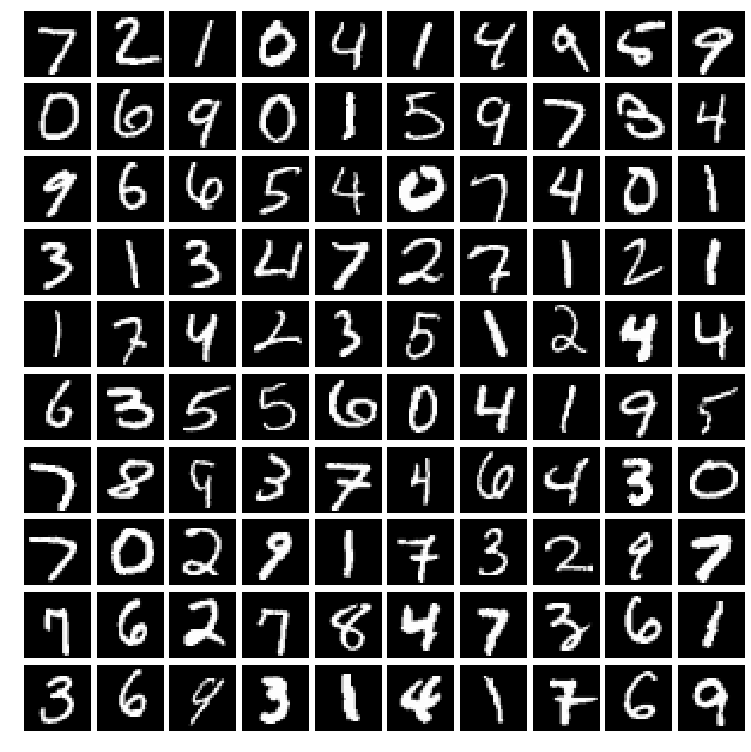

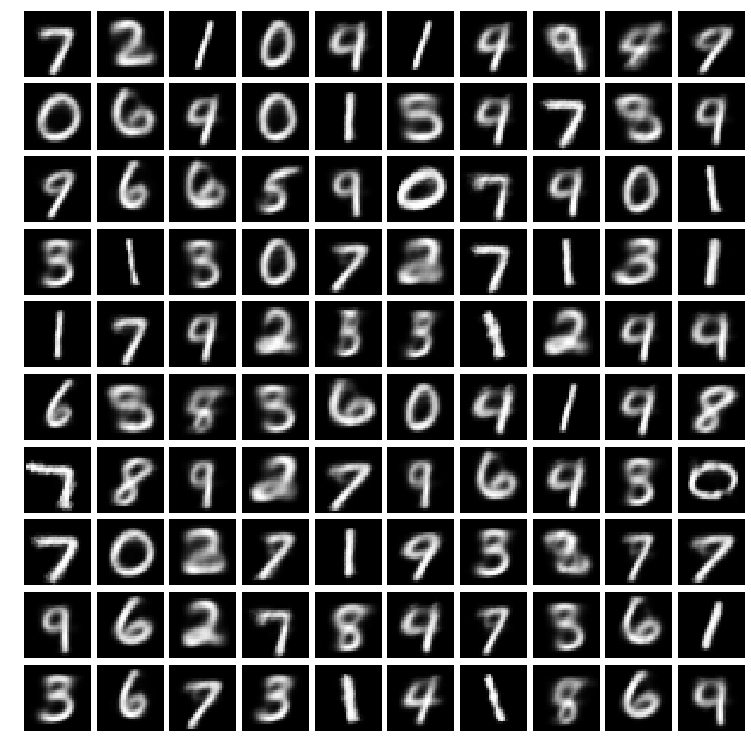

In [153]:
# save some example pictures so we can see what it's done 
example_batch_size = 100
X_comp = X_test[:example_batch_size]
pred_fn = theano.function([input_var], test_prediction)
X_pred = pred_fn(X_comp).reshape(-1, 1, 28, 28)

width = 10
height = 10

plt.figure(figsize = (height,width))
fig = plt.gcf()
fig.set_size_inches(100, 100, forward=True)
gs = mpl.gridspec.GridSpec(height, width)
gs.update(wspace=0.1, hspace=0.1, left=0.1, right=0.2, bottom=0.1, top=0.2) 
for i in range(width*height):
    img = np.reshape(X_comp[i], [28,28])
    plt.subplot(gs[i])
    plt.imshow(np.squeeze(img), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.show()
plt.savefig('MNIST_vae_original.eps', format='eps', dpi=1000)


plt.figure(figsize = (height,width))
fig = plt.gcf()
fig.set_size_inches(100, 100, forward=True)
gs = mpl.gridspec.GridSpec(height, width)
gs.update(wspace=0.1, hspace=0.1, left=0.1, right=0.2, bottom=0.1, top=0.2) 
for i in range(width*height):
    img = np.reshape(X_pred[i], [28,28])
    plt.subplot(gs[i])
    plt.imshow(np.squeeze(img), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.show()
plt.savefig('MNIST_vae_reconstruction.eps', format='eps', dpi=1000)


### MNIST clustering 

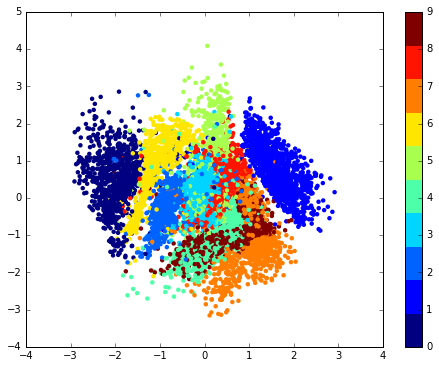

In [154]:
z = get_output(net['Z'], deterministic=True)
test_fun = theano.function([input_var], z)

batch_size = 100
num_test_batches = X_test.shape[0] // batch_size
test_batches = batch_generator(X_test, batch_size, shuffle=False)
    
prediction = []
for index in range(num_test_batches):
    prediction.append(test_fun(next(test_batches)))
    
prediction = np.array(prediction).reshape([-1,2])

plt.figure(figsize=(8, 6)) 
plt.scatter(prediction[:,0], prediction[:,1], c=y_test, cmap=plt.cm.get_cmap("jet", 10),  edgecolor='none')
plt.colorbar()
plt.savefig('MNIST_vae_class_scatter.eps', format='eps', dpi=1000)

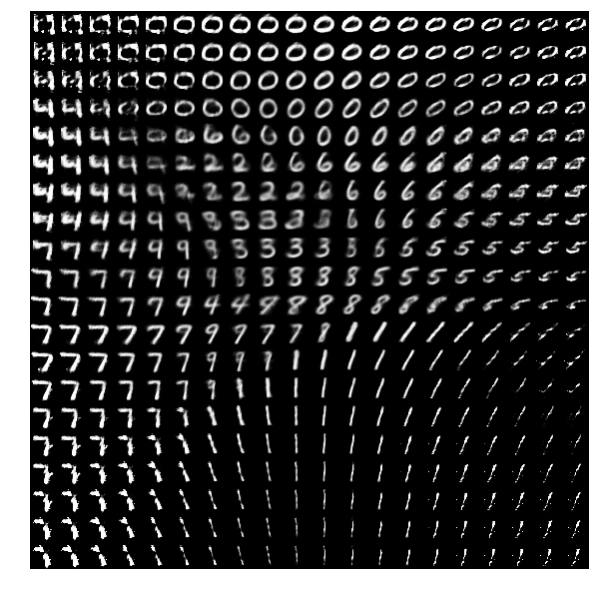

In [158]:
z_var = T.vector()
generated_x = get_output(net['X'], {net['encode_mu']:z_var}, 
            deterministic=True)
gen_fn = theano.function([z_var], generated_x)

num_grid = 20
width = 28
height = 28
tile_img = np.zeros((width*num_grid,height*num_grid))
MIN = np.min(prediction)
MAX = np.max(prediction)
pos = np.linspace(MIN,MAX,num_grid)
for i in range(num_grid):
    for j in range(num_grid):
        z = np.asarray([pos[i], pos[j]], dtype=theano.config.floatX)
        x_gen = gen_fn(z).reshape(-1, 1, width, height)
        tile_img[i*height:(i+1)*height, j*width:(j+1)*width] = x_gen
        
plt.figure(figsize=(10, 10))
plt.imshow(tile_img, cmap='gray')
plt.axis('off')
plt.savefig('MNIST_vae_manifold.eps', format='eps', dpi=1000)

In [ ]:
# !wget http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat

In [277]:
fname = '/home/peter/Data/Frey/frey_rawface.mat'
from scipy.io import loadmat
matfile = loadmat(fname)
all_data = (matfile['ff'] / 255.).T

indices = np.arange(len(all_data))
np.random.shuffle(indices)
indices

width = 20
height = 28
X_train = all_data[indices[:1500]]
X_valid = all_data[indices[1500:]]

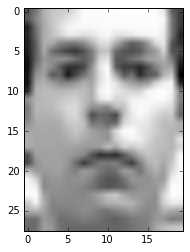

In [278]:
plt.imshow(X_train[10].reshape([height,width]),cmap='gray')

In [251]:
num_encode=2
num_units=200
x_dim = width*height

input_var = T.dmatrix('inputs')
shape = (None, x_dim)
net = {}
net['input'] = layers.InputLayer(shape=shape, input_var=input_var)
net['encode1'] = layers.DenseLayer(net['input'], num_units=200, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus)
net['encode2'] = layers.DenseLayer(net['encode1'], num_units=100, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus)
net['encode_mu'] = layers.DenseLayer(net['encode2'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['encode_logsigma'] = layers.DenseLayer(net['encode2'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['Z'] = VariationalSampleLayer(net['encode_mu'], net['encode_logsigma'])

net['decode1'] = layers.DenseLayer(net['Z'], num_units=100, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus)
net['decode2'] = layers.DenseLayer(net['decode1'], num_units=200, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus)
net['X'] = layers.DenseLayer(net['decode2'], num_units=x_dim,  W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.sigmoid)
#net['decode_logsigma'] = layers.DenseLayer(net['decode2'], num_units=x_dim, nonlinearity=nonlinearities.linear)
#net['X'] = VariationalSampleLayer(net['decode_mu'], net['decode_logsigma'])

In [252]:
def build_loss(net, target_var, deterministic):
    
    z_mu = get_output(net['encode_mu'], deterministic=deterministic)
    z_logsigma = get_output(net['encode_logsigma'], deterministic=deterministic)
    x_mu = get_output(net['X'], deterministic=deterministic)
    x_mu = T.clip(x_mu, 1e-7, 1-1e-7)
    x_logsigma = T.log(T.sqrt(x_mu*(1-x_mu)))
    kl_divergence = 0.5*T.sum(1 + 2*z_logsigma - T.sqr(z_mu) - T.exp(2*z_logsigma), axis=1)
    log_likelihood = T.sum(-0.5*T.log(2*np.float32(np.pi))- x_logsigma - 0.5*T.sqr(target_var-x_mu)/T.exp(2*x_logsigma),axis=1)
    #log_likelihood = T.sum(target_var*T.log(1e-10+x_mu) + (1.0-target_var)*T.log(1e-10+1.0-x_mu), axis=1)
    variational_lower_bound = -log_likelihood - kl_divergence
    prediction = x_mu
    return variational_lower_bound.mean(), prediction

train_loss, train_prediction = build_loss(net, input_var, deterministic=False)
test_loss, test_prediction = build_loss(net, input_var, deterministic=True)

# ADAM updates
params = get_all_params(net['X'], trainable=True)
update_op = updates.adam(train_loss, params, learning_rate=1e-3)
train_fun = theano.function([input_var], train_loss, updates=update_op)
valid_fun = theano.function([input_var], test_loss)

In [259]:
def batch_generator(X, batch_size=128, shuffle=True):
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32)
        
num_epochs = 20
batch_size = 100
num_train_batches = X_train.shape[0] // batch_size
num_valid_batches = X_valid.shape[0] // batch_size
    
for epoch in range(num_epochs):
    train_batches = batch_generator(X_train, batch_size, shuffle=True)
    valid_batches = batch_generator(X_valid, batch_size, shuffle=False)

    train_loss = 0
    for index in range(num_train_batches):
        loss = train_fun(next(train_batches))
        train_loss += loss
        
    valid_loss = 0
    for index in range(num_valid_batches):
        loss = valid_fun(next(valid_batches))
        valid_loss += loss
    if (epoch+1) % 5 == 0:
        print("Epoch {} of {}".format(epoch+1, num_epochs))
        print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))
        print("  validation loss:\t\t{:.6f}".format(valid_loss/num_valid_batches))

Epoch 5 of 20
  training loss:		-3.859308
  validation loss:		-4.436516
Epoch 10 of 20
  training loss:		-3.990816
  validation loss:		-4.582079
Epoch 15 of 20
  training loss:		-3.844937
  validation loss:		-3.837803
Epoch 20 of 20
  training loss:		-3.919101
  validation loss:		-4.430900


### Compare original Frey face vs reconstructed Frey face using only 2 parameters

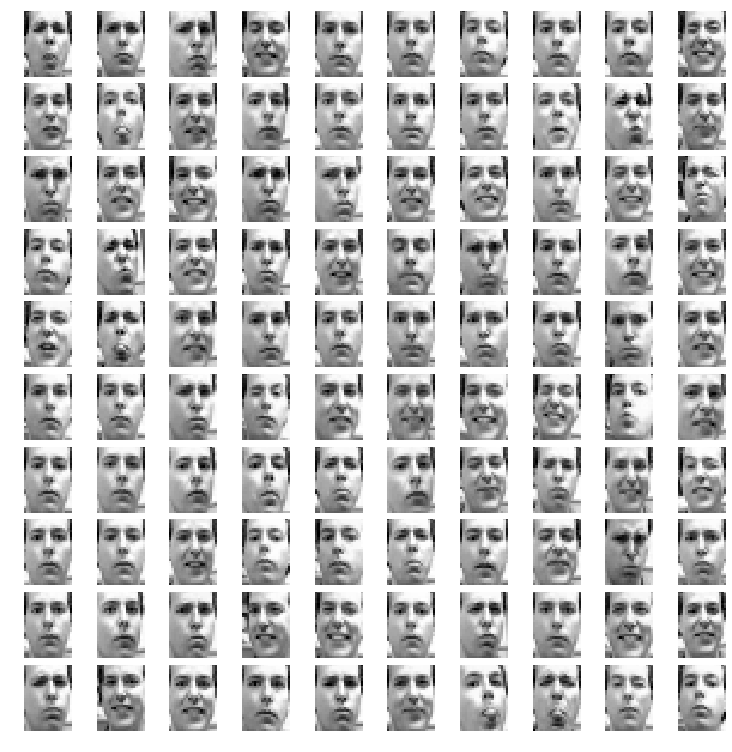

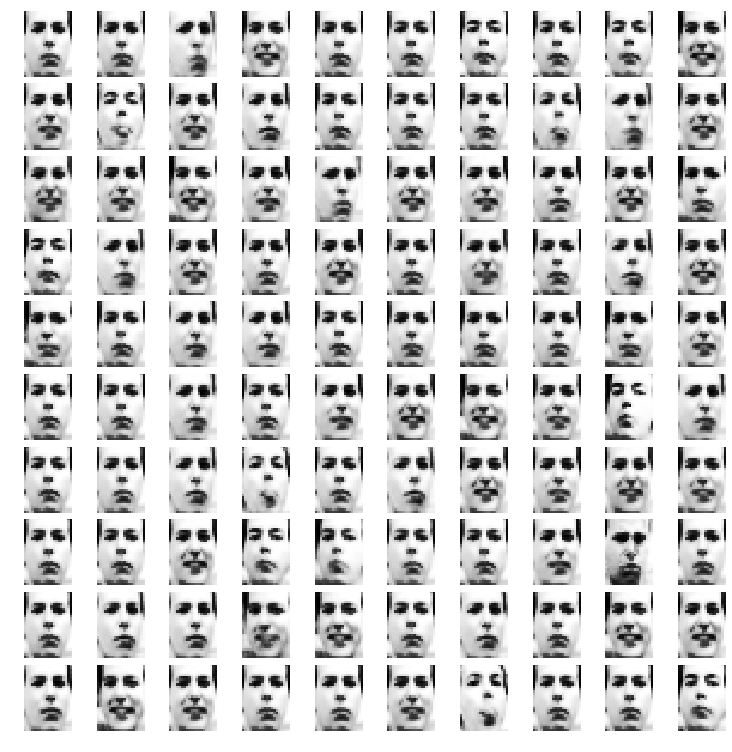

In [272]:
# save some example pictures so we can see what it's done 
example_batch_size = 100
X_comp = X_valid[:example_batch_size]
pred_fn = theano.function([input_var], test_prediction)
X_pred = pred_fn(X_comp).reshape(-1, 1, height, width)

img_width = 10
img_height = 10
scale = 10
plt.figure(figsize = (img_height*scale,img_width*scale))
fig = plt.gcf()
fig.set_size_inches(img_width*scale, img_height*scale, forward=True)
gs = mpl.gridspec.GridSpec(img_height, img_width)
gs.update(wspace=0.1, hspace=0.1, left=0.1, right=0.2, bottom=0.1, top=0.2) 
for i in range(img_width*img_height):
    img = np.reshape(X_comp[i], [height, width])
    plt.subplot(gs[i])
    plt.imshow(np.squeeze(img), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.savefig('Frey_vae_original.eps', format='eps', dpi=200)


plt.figure(figsize = (img_height*scale,img_width*scale))
fig = plt.gcf()
fig.set_size_inches(img_width*scale, img_height*scale, forward=True)
gs = mpl.gridspec.GridSpec(img_height, img_width)
gs.update(wspace=0.1, hspace=0.1, left=0.1, right=0.2, bottom=0.1, top=0.2) 
for i in range(img_width*img_height):
    img = np.reshape(X_pred[i], [height, width])
    plt.subplot(gs[i])
    plt.imshow(np.squeeze(img), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.savefig('Frey_vae_reconstruction.eps', format='eps', dpi=200)


### Learned Frey face manifold

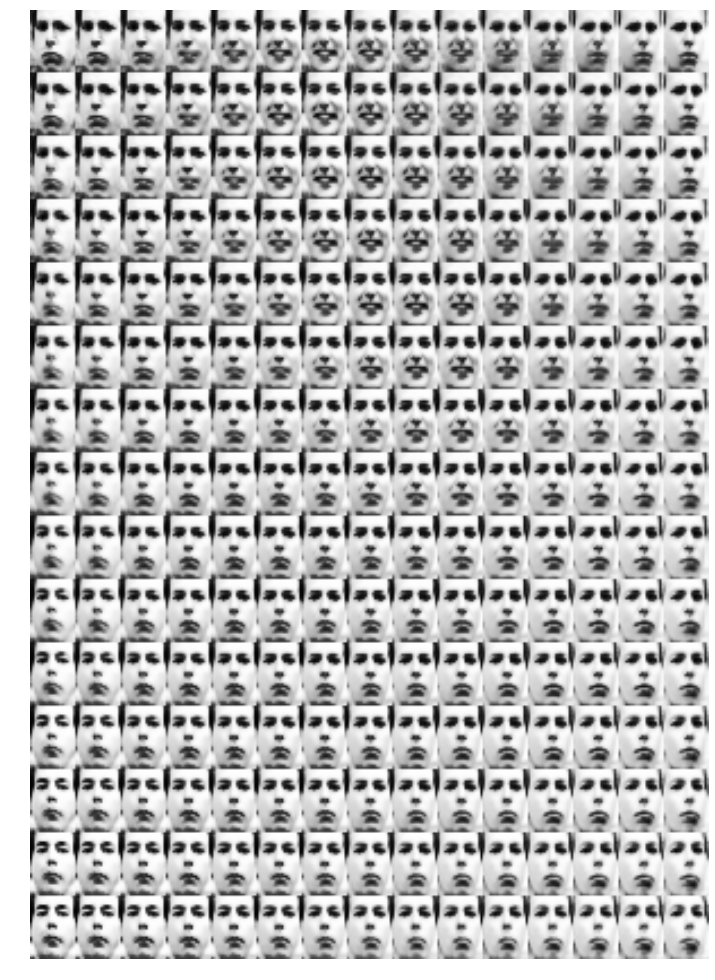

In [274]:
z_var = T.vector()
generated_x = get_output(net['X'], {net['encode_mu']:z_var}, 
            deterministic=True)
gen_fn = theano.function([z_var], generated_x)

num_grid = 15
tile_img = np.zeros((height*num_grid,width*num_grid))
MIN = -2
MAX = 2
pos = np.linspace(MIN,MAX,num_grid)
for i in range(num_grid):
    for j in range(num_grid):
        z = np.asarray([pos[i], pos[j]], dtype=theano.config.floatX)
        x_gen = gen_fn(z)
        tile_img[i*height:(i+1)*height, j*width:(j+1)*width] = np.reshape(x_gen,[height, width])
        
plt.figure(figsize=(17, 17))
plt.imshow(tile_img, cmap='gray')
plt.axis('off')
plt.savefig('Frey_vae_manifold.eps', format='eps', dpi=200)